In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")

# Función para convertir un arreglo en un vector columna. La entrada x es una lista o un vector fila.
def col(x):
    return np.array(np.matrix(x)).T

### Las mediciones de temperatura $T$ (unidades en °C), humedad relativa $H$ (unidades en %), y $\text{CO}_2$ $C$ (partes por millón) en un invernadero real de un cultivo de rosas se modelan como variables aleatorias continuas a través del vector aleatorio $Z = [T;H;C]^T$ . Se desea diseñar un sistema de detección automático basado en MLE que genere una alarma cuando se presente una medición anómala. Para esto, nos dan en el archivo *greenhouse3d.txt* 300 observaciones conjuntas de las variables de temperatura $T$ (primera columna), humedad $H$ (segunda columna), y $\text{CO}_2$ $C$ (tercera columna).

# Punto 1

## a) Realice una gráfica 3-dimensional de las observaciones de temperatura vs humedad vs $\text{CO}_2$, y realice una inspección visual de los datos analizando su comportamiento.

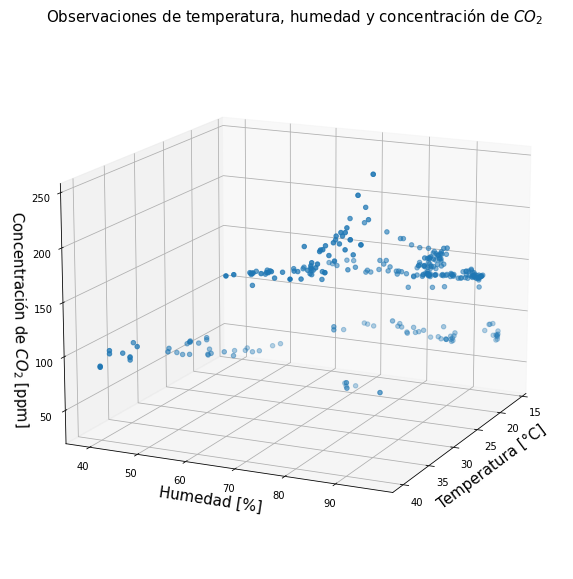

interactive(children=(IntSlider(value=0, description='E', max=90, min=-90, step=5), IntSlider(value=0, descrip…

In [2]:
# Se importan los datos del .txt
filename1 = 'Datos invernadero/greenhouseData3d.txt'
T = np.loadtxt(filename1)[:, 0]
H = np.loadtxt(filename1)[:, 1]
C = np.loadtxt(filename1)[:, 2]

# Create the figure
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

# Plot the values
ax.scatter(T, H, C, marker='o')
ax.view_init(elev=15, azim=25)
ax.set_xlabel(r'Temperatura [°C]', fontsize=15)
ax.set_ylabel(r'Humedad [%]', fontsize=15)
ax.set_zlabel(r'Concentración de $CO_2$ [ppm]', fontsize=15)
ax.set_title(r'Observaciones de temperatura, humedad y concentración de $CO_2$', fontsize=15)

# plt.savefig('datos3d.eps', format='eps')
plt.show()

def plotter(E, A):
    fig = plt.figure(figsize = [12, 8])
    ax = fig.gca(projection='3d') # Set up the 3d axis as a 3D plot
    ax.scatter(T, H, C, cmap=cm.coolwarm)
    ax.set_xlabel(r'Temperatura [°C]', fontsize=15)
    ax.set_ylabel(r'Humedad [%]', fontsize=15)
    ax.set_zlabel(r'Concentración de $CO_2$ [ppm]', fontsize=15)
    ax.set_title(r'Observaciones de temperatura, humedad y concentración de $CO_2$', fontsize=15)
    ax.view_init(elev=E, azim=A)
    plt.show()


from ipywidgets import interactive
iplot = interactive(plotter,
                    E = (-90,90, 5), 
                    A = (-90,90,5)
                    )
iplot

### Se puede notar una alta concentración de datos alrededor de los 20 °C y 25 °C de temperatura, el 70\% y 90\% de humedad y entre las 100 y 150 ppm de concentración de dióxido de carbono. También hay otra zona de alta concentración de datos para temperaturas entre los 20 °C y los 36 °C, para concentraciones de dióxido de carbono inferiores a 100 ppm y humedad relativa entre el 40\% y 60\%.

## b) Estime la mejor distribución Gaussiana de Z utilizando MLE, e indique la función resultante (es decir, una sola Gaussiana). Recuerde que para estimar la distribución Gaussiana basta con estimar el vector de valores esperados y la matriz de covarianza. No puede utilizar funciones predefinidas para estimar el vector de medias y la matriz de covarianza. Implemente su propia rutina para hacer este cálculo.

In [3]:
# Estimación de vector de medias usando MLE

# Creamos vectores de la forma z = [T, H, C]^T donde T es temperatura, H es la humedad y C es la concentración de CO2. Los vamos a colocar en una matriz THC de 3xlen(T), donde len(T) = len(H) = len(C).
THC = np.zeros((3, len(T)))
n, m = np.shape(THC)

# Llenamos la matriz THC
for i in range(m):
    THC[0, i] = T[i]
    THC[1, i] = H[i]
    THC[2, i] = C[i]

# Creamos la estimación de la media mu_Z
mu_Z = np.zeros((3,1))
for i in range(m):
    mu_Z = mu_Z + col(THC[:, i])
mu_Z = mu_Z/m
print(f'Estimación de la media mu_Z: \n {mu_Z}\n')

# Creamos la estimación de la matriz de covarianza Q_Z
Q_Z = np.zeros((3,3))
for i in range(m):
    Q_Z = Q_Z + (col(THC[:,i])-mu_Z)@(col(THC[:,i])-mu_Z).T
Q_Z = Q_Z/(m-1)
print(f'Estimación de la matriz de covarianza Q_Z: \n {Q_Z}\n')

Estimación de la media mu_Z: 
 [[ 24.00886667]
 [ 79.002     ]
 [137.50666667]]

Estimación de la matriz de covarianza Q_Z: 
 [[  24.08500339  -63.56876696   22.11368651]
 [ -63.56876696  224.22534716  167.39396656]
 [  22.11368651  167.39396656 1753.66885173]]



## c) Determine el umbral de decisión  que define la detección. Es decir, dada una nueva observación $z \in \mathbb{R}^3$, se considera como dato anómalo si $f_Z(z) < \gamma$. Escriba la ecuación completa de la regla de decisión. Explique y justifique la elección de $\gamma$. Para esta explicación, proponga alguna forma de realizar una inspección visual de la regla de decisión. Por ejemplo, una forma de hacerlo es generar datos aleatorios uniformes dentro de una caja que encierre las observaciones de la base de datos del invernadero, y pintar de un color diferente aquellos que son considerados como anómalos de acuerdo con la regla de decisión.

### Tenemos
### $$f_Z(z) = \frac{1}{2\pi\sqrt{\text{det}(\hat{Q}_Z)}}\exp\left({-\frac{1}{2}(z-\mu_Z)^T\hat{Q}_Z^{-1}(z-\mu_Z)}\right)$$
### Definimos regla de decisión para observaciones típicas:
### $$f_Z(z) \geq \gamma$$ 
### Definimos regla de decisión para observaciones anómalas
### $$f_Z(z) < \gamma$$

In [4]:
def gauss(x, mu, Cx):
    n = np.shape(Cx)[0]
    return float((1/(np.sqrt((2*np.pi)**(n)*(np.linalg.det(Cx)))))*np.exp((-1/2)*(np.transpose(x-mu)@np.linalg.inv(Cx))@(x-mu)))

# Muestras de temperatura
muestrasT = np.random.uniform(15, 40, 1000)

# Muestras de humedad
muestrasH = np.random.uniform(40, 100, 1000)

# Muestras de CO2
muestrasC = np.random.uniform(0, 230, 1000)

# Para definir el valor de gamma, vamos a evaluar los datos que tenemos en la gaussiana que se estimó con MLE y vamos a mirar los mayores valores que retorna, para así 
# establecer el gamma en un valor cercano a ese.
valores = []
for i in range(m):
    z = col(THC[:,i])
    val = gauss(z, mu_Z, Q_Z)
    valores.append(val)

# Valor mínimo de la función Gaussiana
print(f'Valor mínimo de la función Gaussiana: {np.min(valores)}')
# Valor máximo de la función Gaussiana
print(f'Valor máximo de la función Gaussiana: {np.max(valores)}')
# Definición del gamma
gamma = 4.7e-9
print(f'Gamma escogido: {gamma}')

Valor mínimo de la función Gaussiana: 4.738645728434383e-09
Valor máximo de la función Gaussiana: 5.57235046790959e-05
Gamma escogido: 4.7e-09


In [5]:
# Se grafica una caja de muestras uniformes alrededor de los datos reales.
def plotter2(E, A):
    fig = plt.figure(figsize = [12, 8])
    ax = fig.gca(projection='3d') # Set up the 3d axis as a 3D plot
    ax.scatter(T, H, C, cmap=cm.coolwarm, c='k')
    ax.scatter(muestrasT, muestrasH, muestrasC, cmap=cm.coolwarm)
    ax.set_xlabel(r'Temperatura [°C]', fontsize=15)
    ax.set_ylabel(r'Humedad [%]', fontsize=15)
    ax.set_zlabel(r'Concentración de $CO_2$ [ppm]', fontsize=15)
    ax.set_title(r'Datos de temperatura, humedad y concentración de $CO_2$', fontsize=15)
    ax.view_init(elev=E, azim=A)
    plt.show()

from ipywidgets import interactive
iplot = interactive(plotter2,
                    E = (-90,90, 5), 
                    A = (-90,90,5)
                    )
iplot

interactive(children=(IntSlider(value=0, description='E', max=90, min=-90, step=5), IntSlider(value=0, descrip…

In [6]:
# Creamos vectores de muestras uniformes de la forma z = [T, H, C]^T donde T es temperatura, H es la humedad y C es la concentración de CO2. Los vamos a colocar en una matriz THC2 de 3xlen(T), donde len(T) = len(H) = len(C).
THC2 = np.zeros((3, len(muestrasT)))
n2, m2 = np.shape(THC2)

# Llenamos la matriz THC2
for i in range(m2):
    THC2[0, i] = muestrasT[i]
    THC2[1, i] = muestrasH[i]
    THC2[2, i] = muestrasC[i]

# Se crean listas para guardar los datos detectados como típicos y anómalos.
tipicosT = []
tipicosH = []
tipicosC = []
anomalosT = []
anomalosH = []
anomalosC = []

# Se aplica la regla de decisión para los datos de las muestras uniformes.
for i in range(m2):
    z = col(THC2[:,i])
    if gauss(z, mu_Z, Q_Z) >= gamma:
        tipicosT.append(z[0])
        tipicosH.append(z[1])
        tipicosC.append(z[2])
    else:
        anomalosT.append(z[0])
        anomalosH.append(z[1])
        anomalosC.append(z[2])

# Se grafica la detección de fallas para los datos uniformes.
def plotter3(E, A):
    fig = plt.figure(figsize = [12, 8])
    ax = fig.gca(projection='3d') # Set up the 3d axis as a 3D plot
    ax.scatter(tipicosT, tipicosH, tipicosC, c='g', label=r'Observaciones típicas')
    ax.scatter(anomalosT, anomalosH, anomalosC, c='k', label=r'Observaciones anómalas')
    ax.scatter(T, H, C, c='b', cmap=cm.coolwarm, label=r'Observaciones reales')
    ax.set_xlabel(r'Temperatura [°C]', fontsize=15)
    ax.set_ylabel(r'Humedad [%]', fontsize=15)
    ax.set_zlabel(r'Concentración de $CO_2$ [ppm]', fontsize=15)
    ax.set_title(r'Datos de temperatura, humedad y concentración de $CO_2$', fontsize=15)
    ax.view_init(elev=E, azim=A)
    plt.legend()
    plt.show()

from ipywidgets import interactive
iplot = interactive(plotter3,
                    E = (-90,90, 5), 
                    A = (-90,90,5)
                    )
iplot


interactive(children=(IntSlider(value=0, description='E', max=90, min=-90, step=5), IntSlider(value=0, descrip…

## d) Reescriba la regla de decisión en el enunciado b) a través de una forma cuadrática. Es decir, encuentre la constante $\alpha$ y la matriz $M$, tal que, dada una observacion $z \in \mathbb{R}^3$, ésta es considerada como anómala si $(z - \mu)^TM(z - \mu) > \alpha$.

In [7]:
# Para encontrar M y alpha vamos a mirar primero para qué valores de z se cumple que f_Z(z) >= gamma
vals_may = []
zetas = []

for i in range(m):
    z = col(THC[:,i])
    val = gauss(z, mu_Z, Q_Z)
    if val >= gamma:
        vals_may.append(val)
        zetas.append(z)

# Para esos valores de z, miramos cuánto retorna la operación (z-mu_Z)^T Q^-1 (z-mu_Z).
# El valor más grande que retorne la operación será el alpha.
alphas = []
for j in range(len(zetas)):
    cuad = np.round(float((zetas[j]-mu_Z).T@np.linalg.inv(Q_Z)@(zetas[j]-mu_Z)), 3)
    alphas.append(cuad)

# Se encuentra el índice del z que generó ese alpha para así encontrar el valor de alpha.
indice = alphas.index(np.max(alphas))
alpha = np.round(float((zetas[indice]-mu_Z).T@np.linalg.inv(Q_Z)@(zetas[indice]-mu_Z)), 3)
print(f'alpha = {alpha}')

alpha = 18.885


### Regla de decisión escrita como una forma cuadrática

### Dato anómalo si
### $$(z-\mu_Z)^TQ_Z^{-1}(z-\mu_Z) > 18.885$$
### Lo que significa que $M = Q_Z^{-1}$ y $\alpha = 18.885$

In [8]:
# Estas líneas se corren para comprobar que esta regla de decisión es equivalente a la primera. 
# Se encuentra que sí lo son, pero hay ciertas diferencias en los decimales por la precisión numérica que se utiliza.
# Para probar esto, basta con imprimir cualquiera de las listas tipicosT2, tipicosH2 o tipicosC2 al lado de alguna de las listas tipicosT, tipicosH o tipicosC para ver que son iguales.
tipicosT2 = []
tipicosH2 = []
tipicosC2 = []
anomalosT2 = []
anomalosH2 = []
anomalosC2 = []

for i in range(m2):
    z = col(THC2[:,i])
    if np.round(float((z-mu_Z).T@np.linalg.inv(Q_Z)@(z-mu_Z)), 3) <= alpha:
        tipicosT2.append(z[0])
        tipicosH2.append(z[1])
        tipicosC2.append(z[2])
    else:
        anomalosT2.append(z[0])
        anomalosH2.append(z[1])
        anomalosC2.append(z[2])

## e) Considere las nuevas mediciones dentro del invernadero en el archivo *datosNuevos.txt*. Dada la regla de decisión encontrada en c) o d) (las reglas en estos enunciados son exactamente la misma pero escrita de diferente forma), determine el porcentaje de mediciones que son anómalas.

In [9]:
# Se importan los datos del nuevo .txt.
filename2 = 'Datos invernadero/datosNuevos_greenhouseData3d.txt'
Tnuevos = np.loadtxt(filename2)[:, 0]
Hnuevos = np.loadtxt(filename2)[:, 1]
Cnuevos = np.loadtxt(filename2)[:, 2]

# Creamos vectores con los nuevos datos de la forma z = [T, H, C]^T donde T es temperatura, H es la humedad y C es la concentración de CO2. Los vamos a colocar en una matriz THC3 de 3xlen(T), donde len(T) = len(H) = len(C).
THC3 = np.zeros((3, len(Tnuevos)))
n3, m3 = np.shape(THC3)

# Llenamos la matriz THC3
for i in range(m3):
    THC3[0, i] = Tnuevos[i]
    THC3[1, i] = Hnuevos[i]
    THC3[2, i] = Cnuevos[i]

# Aplicamos la regla de decisión para los nuevos datos.
# Creamos dos listas: una para las observaciones consideradas como normales y otra para las observaciones consideradas anómalas.
normales = []
anomalas = []
for i in range(m3):
    z = col(THC3[:,i])
    expr2 = gauss(z, mu_Z, Q_Z)
    if expr2 >= gamma:
        normales.append(z)
    else:
        anomalas.append(z)

percent_anomalas = np.round(len(anomalas)/(len(anomalas) + len(normales)), 4)
print(f'Porcentaje de mediciones anómalas: {percent_anomalas*100}%')


Porcentaje de mediciones anómalas: 65.0%


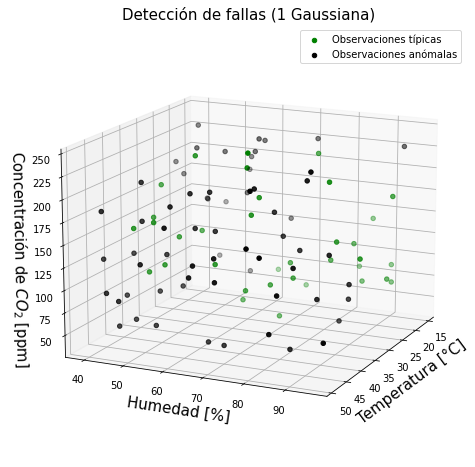

interactive(children=(IntSlider(value=0, description='E', max=90, min=-90, step=5), IntSlider(value=0, descrip…

In [10]:
# Se realiza el mismo procedimiento de la celda anterior para los datos nuevos, pero esta vez para graficarlos en R^3.
tipicosT3 = []
tipicosH3 = []
tipicosC3 = []
anomalosT3 = []
anomalosH3 = []
anomalosC3 = []

for i in range(m3):
    z = col(THC3[:,i])
    if gauss(z, mu_Z, Q_Z) >= gamma:
        tipicosT3.append(z[0])
        tipicosH3.append(z[1])
        tipicosC3.append(z[2])
    else:
        anomalosT3.append(z[0])
        anomalosH3.append(z[1])
        anomalosC3.append(z[2])

fig = plt.figure(figsize = [12, 8])
ax = fig.gca(projection='3d') # Set up the 3d axis as a 3D plot
ax.scatter(tipicosT3, tipicosH3, tipicosC3, c='g', label=r'Observaciones típicas')
ax.scatter(anomalosT3, anomalosH3, anomalosC3, c='k', label=r'Observaciones anómalas')
ax.view_init(elev=15, azim=25)
ax.set_xlabel(r'Temperatura [°C]', fontsize=15)
ax.set_ylabel(r'Humedad [%]', fontsize=15)
ax.set_zlabel(r'Concentración de $CO_2$ [ppm]', fontsize=15)
ax.set_title(r'Detección de fallas (1 Gaussiana)', fontsize=15)
plt.legend()
# plt.savefig('calsif1gauss.eps', format='eps')
plt.show()


def plotter4(E, A):
    fig = plt.figure(figsize = [12, 8])
    ax = fig.gca(projection='3d') # Set up the 3d axis as a 3D plot
    ax.scatter(tipicosT3, tipicosH3, tipicosC3, c='g', label=r'Observaciones típicas')
    ax.scatter(anomalosT3, anomalosH3, anomalosC3, c='k', label=r'Observaciones anómalas')
    ax.set_xlabel(r'Temperatura [°C]', fontsize=15)
    ax.set_ylabel(r'Humedad [%]', fontsize=15)
    ax.set_zlabel(r'Concentración de $CO_2$ [ppm]', fontsize=15)
    ax.set_title(r'Datos de temperatura, humedad y concentración de $CO_2$', fontsize=15)
    ax.view_init(elev=E, azim=A)
    plt.legend()
    plt.show()

from ipywidgets import interactive
iplot = interactive(plotter4,
                    E = (-90,90, 5), 
                    A = (-90,90,5)
                    )
iplot

## f) Repita los enunciados b), c), y e) ahora con una distribución de la forma $f_Z(z) = \sum_{k=1}^{3}\alpha_kN(z; \mu_k, Q_k)$, encontrada con el algoritmo EM. No puede utilizar funciones predefinidas para encontrar la distribución combindada. Implemente su propio algoritmo EM. Compare los resultados de realizar detección de anomalías usando una sola Gaussiana en el enunciado e) con los obtenidos al utilizar una combinación de Gaussianas (por ejemplo, el procentaje de muestras detectadas como anómalas, una gráfica comparando las muestras del dataset inicial utilizando para ejecutar el algoritmo EM con las muestras consideradas como anómalas, etc.).

In [11]:
# Función para crear una nueva lista de thetas (parámetros), dependiendo del número de funciones n que se quieran combinar.
def create_thetas(n):
    x = [[] for num in range(n)]
    return x

### Se define el algoritmo EM

In [12]:
# Entradas
# maxIt: máximas iteraciones que se permite que el algoritmo haga.
# tol: tolerancia del algoritmo para la condición de terminación.
# k: número de funciones Gaussianas que se planea combinar.
# thetak0: lista de parámetros thetak, cada elemento de la lista es una lista que contiene una media y una matriz de covarianza.
# alphak: lista de parámetros alphak, cada elemento de la lista es un valor de alpha.
# datos: arreglo de los datos sobre los cuales se quiere encontrar la función de densidad compuesta. Se ingresan en forma de matriz en donde cada fila es un dato y cada columna es un componente del dato.

# Salidas
# thetak_final: arreglo de parámetros de las funciones combinadas que forman la función compuesta que mejor se ajusta a los datos.
# alphak_final: arreglo de pesos de las funciones combinadas que forman la función compuesta que mejor se ajusta a los datos.
# c: Número de iteraciones que tomó el algoritmo
def EM(maxIt, tol, k, thetak0, alphak, datos):

    c = 0 # Contador para el while.
    m = len(datos) # Cantidad de datos.
    Y = np.zeros((m,len(thetak0))) # Matriz de gammas: cada columna corresponde a cada gamma_k.
    norma = 100 # Norma para la condición de terminación.
    regu = 0.01*np.eye(3)  # Parámetro de regularización.

    while(c < maxIt and norma > tol ):

        # E-Step
        den = 0
        for r in range(len(thetak0)):
            Nm = np.zeros((m, 1))
            for i in range(m):
                Nm[i] = gauss(col(datos[i]), thetak0[r][0], thetak0[r][1] + regu)
            den = den + alphak[r]*Nm

        num = 0
        for r in range(len(thetak0)):
            Nm = np.zeros((m, 1))
            for i in range(m):
                Nm[i] = gauss(col(datos[i]), thetak0[r][0], thetak0[r][1] + regu)
            num = alphak[r]*Nm
            Y[:,r] = col(np.divide(num, den)) # Se va llenando la matriz de gammas.

        # M-Step

        # En este recorrido se calcula el Nk
        Nk = []
        suma = 0
        for j in range(len(thetak0)):
            suma = 0
            for i in range(m):
                suma = suma + Y[:,j][i]
            Nk.append(suma)

        # En este recorrido se calcula el alphak
        alphak = []
        for i in range(len(thetak0)):
            alphak.append(Nk[i]/m)

        # En este recorrido se calculan las nuevas medias (muk).
        muk = []
        suma = 0
        for j in range(len(thetak0)):
            suma = 0
            for i in range(m):
                suma = suma + Y[:,j][i]*col(datos[i])
            muk.append(suma/Nk[j])

        # En este recorrido se calculan las nuevas matrices de covarianza (Ck).
        Ck = []
        suma = 0
        for j in range(len(thetak0)):
            suma = 0
            for i in range(m):
                dato = col(datos[i])
                suma = suma + Y[:,j][i]*(dato-muk[j])@(dato-muk[j]).T
            Ck.append(suma/Nk[j])

        # Se crea una nueva lista de thetas, para luego guardar los encontrados en la iteración actual.
        thetak_new = create_thetas(len(thetak0))
        for i in range(len(thetak0)):
            thetak_new[i].append(muk[i])
            thetak_new[i].append(Ck[i])

        # Se calcula la diferencia entre los parámetros nuevos y los anteriores y se calcula su norma para saber si tienen valores parecidos.
        norma = np.linalg.norm(thetak_new[0][0] - thetak0[0][0])

        # El valor "nuevo" de thetak ahora será el usado en la siguiente iteración.
        thetak0 = thetak_new
        c+=1        

    # # Cuando se cumpla alguna de las condiciones de terminación (iteraciones o norma).
    thetak_final = thetak0
    alphak_final = alphak

    return thetak_final, alphak_final, c

### Combinación de 3 Gaussianas

In [13]:
# Condiciones iniciales
k = 3

mu1 = np.array([[30], [75], [160]])
mu2 = np.array([[20], [90], [150]])
mu3 = np.array([[30], [50], [75]])

C1 = 100*np.eye(3)
C2 = 100*np.eye(3)
C3 = 100*np.eye(3)

thetak = []
theta1 = [mu1, C1]
theta2 = [mu2, C2]
theta3 = [mu3, C3]

thetak.append(theta1)
thetak.append(theta2)
thetak.append(theta3)

alphak = []
alpha1 = 1/3
alpha2 = 1/3
alpha3 = 1/3

alphak.append(alpha1)
alphak.append(alpha2)
alphak.append(alpha3)

maxIts = 1000
tol = 10**-5

THC_data = THC.T

# Se corre el algoritmo
params3, alphas3, its3 = EM(maxIts, tol, k, thetak, alphak, THC_data)

print(f'Número de iteraciones: {its3}\n')
print(f'Media de la primera función:\n{params3[0][0]}\n')
print(f'Matriz de covarianza de la primera función:\n{params3[0][1]}\n')
print(f'alpha_1 = {np.round(alphas3[0], 3)}')
print('--------------------\n')
print(f'Media de la segunda función:\n{params3[1][0]}\n')
print(f'Matriz de covarianza de la segunda función:\n{params3[1][1]}\n')
print(f'alpha_2 = {np.round(alphas3[1], 3)}')
print('--------------------\n')
print(f'Media de la tercera función:\n{params3[2][0]}\n')
print(f'Matriz de covarianza de la tercera función:\n{params3[2][1]}\n')
print(f'alpha_3 = {np.round(alphas3[2], 3)}')

Número de iteraciones: 67

Media de la primera función:
[[ 26.89850031]
 [ 75.62308269]
 [174.15675368]]

Matriz de covarianza de la primera función:
[[ 12.59551659 -25.27187825  -5.98668459]
 [-25.27187825  87.20702712  45.94745505]
 [ -5.98668459  45.94745505 360.02432232]]

alpha_1 = 0.35
--------------------

Media de la segunda función:
[[ 20.96577645]
 [ 89.70080267]
 [149.44768475]]

Matriz de covarianza de la segunda función:
[[  1.12256265  -4.78918118   2.14207656]
 [ -4.78918118  24.47405995 -12.29859047]
 [  2.14207656 -12.29859047  23.98318288]]

alpha_2 = 0.36
--------------------

Media de la tercera función:
[[24.29097768]
 [69.81815705]
 [78.4196685 ]]

Matriz de covarianza de la tercera función:
[[  44.51189173 -127.23553791   14.34698823]
 [-127.23553791  394.80945665  -16.42300817]
 [  14.34698823  -16.42300817  271.11040297]]

alpha_3 = 0.29


In [14]:
# Para definir el valor de gamma, vamos a evaluar los datos originales en la combinación de gaussianas que se estimó con el algoritmo EM y vamos a mirar los menores valores que retorna, para así 
# establecer el gamma en un valor cercano a ese.
valores_comb = []
for i in range(m):
    z = col(THC[:,i])
    val = alphas3[0]*gauss(z, params3[0][0], params3[0][1]) + alphas3[1]*gauss(z, params3[1][0], params3[1][1]) + alphas3[2]*gauss(z, params3[2][0], params3[2][1])
    valores_comb.append(val)

# Valor mínimo de la función Gaussiana
print(f'Valor mínimo de la combinación de Gaussianas: {np.min(valores_comb)}')
# Valor máximo de la función Gaussiana
print(f'Valor máximo de la combinación de Gaussianas: {np.max(valores_comb)}')
# Definición del gamma
gamma2 = 1.04e-8
print(f'Gamma escogido: {gamma2}')

Valor mínimo de la combinación de Gaussianas: 1.0448626461390402e-08
Valor máximo de la combinación de Gaussianas: 0.002096054141526032
Gamma escogido: 1.04e-08


In [15]:
# Aplicamos la regla de decisión para los nuevos datos.
# Creamos dos listas: una para las observaciones consideradas como normales y otra para las observaciones consideradas anómalas.
normales2 = []
anomalas2 = []
for i in range(m3):
    z = col(THC3[:,i])
    expr2 = alphas3[0]*gauss(z, params3[0][0], params3[0][1]) + alphas3[1]*gauss(z, params3[1][0], params3[1][1]) + alphas3[2]*gauss(z, params3[2][0], params3[2][1])
    if expr2 >= gamma2:
        normales2.append(z)
    else:
        anomalas2.append(z)

percent_anomalas2 = np.round(len(anomalas2)/(len(anomalas2) + len(normales2)), 2)
print(f'Porcentaje de mediciones anómalas: {percent_anomalas2*100}%')


Porcentaje de mediciones anómalas: 67.0%


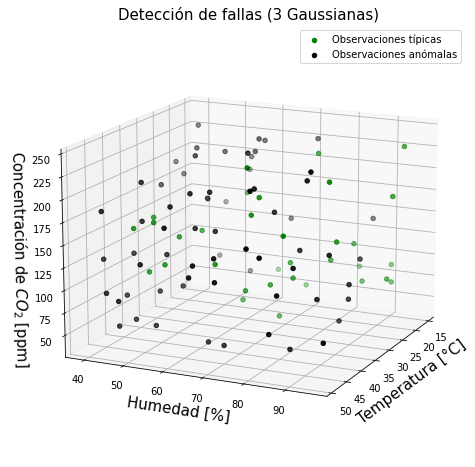

interactive(children=(IntSlider(value=0, description='E', max=90, min=-90, step=5), IntSlider(value=0, descrip…

In [16]:
# Se realiza el mismo procedimiento anterior, pero ahora para graficar los resultados en R^3. 
tipicosTEM = []
tipicosHEM = []
tipicosCEM = []
anomalosTEM = []
anomalosHEM = []
anomalosCEM = []

for i in range(m3):
    z = col(THC3[:,i])
    if alphas3[0]*gauss(z, params3[0][0], params3[0][1]) + alphas3[1]*gauss(z, params3[1][0], params3[1][1]) + alphas3[2]*gauss(z, params3[2][0], params3[2][1]) >= gamma2:
        tipicosTEM.append(z[0])
        tipicosHEM.append(z[1])
        tipicosCEM.append(z[2])
    else:
        anomalosTEM.append(z[0])
        anomalosHEM.append(z[1])
        anomalosCEM.append(z[2])

fig = plt.figure(figsize = [12, 8])
ax = fig.gca(projection='3d') # Set up the 3d axis as a 3D plot
ax.scatter(tipicosTEM, tipicosHEM, tipicosCEM, c='g', label=r'Observaciones típicas')
ax.scatter(anomalosTEM, anomalosHEM, anomalosCEM, c='k', label=r'Observaciones anómalas')
ax.view_init(elev=15, azim=25)
ax.set_xlabel(r'Temperatura [°C]', fontsize=15)
ax.set_ylabel(r'Humedad [%]', fontsize=15)
ax.set_zlabel(r'Concentración de $CO_2$ [ppm]', fontsize=15)
ax.set_title(r'Detección de fallas (3 Gaussianas)', fontsize=15)
plt.legend()
# plt.savefig('calsif3gauss.eps', format='eps')
plt.show()

def plotter5(E, A):
    fig = plt.figure(figsize = [12, 8])
    ax = fig.gca(projection='3d') # Set up the 3d axis as a 3D plot
    ax.scatter(tipicosTEM, tipicosHEM, tipicosCEM, c='g', label=r'Observaciones típicas')
    ax.scatter(anomalosTEM, anomalosHEM, anomalosCEM, c='k', label=r'Observaciones anómalas')
    ax.set_xlabel(r'Temperatura [°C]', fontsize=15)
    ax.set_ylabel(r'Humedad [%]', fontsize=15)
    ax.set_zlabel(r'Concentración de $CO_2$ [ppm]', fontsize=15)
    ax.set_title(r'Datos de temperatura, humedad y concentración de $CO_2$', fontsize=15)
    ax.view_init(elev=E, azim=A)
    plt.legend()
    plt.show()

from ipywidgets import interactive
iplot = interactive(plotter5,
                    E = (-90,90, 5), 
                    A = (-90,90,5)
                    )
iplot